# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com) is an online movie ratings aggregator). He published his analysis in [this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- On one occasion, a movie was rounded up to an entire star, from a rating of 4 to a rating of 5.

![alt text](https://s3.amazonaws.com/dq-content/288/s1gp_actual_vs_displayed.png "Rating comparison")



The two distributions are displayed using a simple line plot. The variable being examined is the *movie rating* (ranked from 0 to 5 stars), measured by relative frequency (percentage) on the y-axis.

Both distributions are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high. The *Actual rating* distribution clearly appeared on the left of *Fandango rating*, implying that Fandango inflates the movie ratings under the hood.


![alt text](https://s3.amazonaws.com/dq-content/288/s1gp_fdg_stars.png)



Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

Thus, in this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.


Fortunately, we have ready-made data for both these periods of time:
- Walt Hickey made the data he analyzed publicly available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.
- One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available [on GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline

In [3]:
fandango_previous = pd.read_csv('fandango_score_comparison.csv')
fandango_previous = fandango_previous.copy()[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]
fandango_previous.head(10)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5
5,The Water Diviner (2015),4.5,4.0,397,0.5
6,Irrational Man (2015),4.0,3.5,252,0.5
7,Top Five (2014),4.0,3.5,3223,0.5
8,Shaun the Sheep Movie (2015),4.5,4.0,896,0.5
9,Love & Mercy (2015),4.5,4.0,864,0.5


In [5]:
fandango_after = pd.read_csv('movie_ratings_16_17.csv')
fandango_after = fandango_after.copy()[['movie', 'year', 'fandango']]
fandango_after.head(10)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0
6,A Street Cat Named Bob,2016,4.5
7,Alice Through the Looking Glass,2016,4.0
8,Allied,2016,4.0
9,Amateur Night,2016,3.5


Our goal is to determine if there is changes in Fandango's rating after Hickey's analysis. Therefore, our population of interest should span accross all Fandango's movies rating on its websites, regardless of the years.

Because of our defined population of interest, our sample should be representative of the population based on the data that we have, otherwise, we will run ito sampling error and ultimately, wrong conclusion. 

From Hickey's article and his sampling's criterias in the [`README.md`](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md):
- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

The sampling conditions for our other sample were (as it can be read in the [`README.md`](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/README.md):
- The movie must have been released in 2016 or later.
- The movie must have had a considerable number of votes and reviews (unclear how many).

Both samples are not random becasue not all movies had the chance to be sampled (movie must match the criteria for it to be included). So it is questionable whether our available samples are representative of the population we're interested in describing. It is not, mostly because these samples are subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years. 

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.


### Changing the Goal of our Analysis

At this point, we have at least two alternatives: either we collect new data, or we change the goal of our analysis by placing some limitations on it.

We decide on the latter. Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

### Isolating the Samples We Need

With this new research goal, we have two populations of interest:

- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

We need to be clear about what counts as popular movies. We'll use Hickey's benchmark of 30 fan ratings and count a movie as popular only if it has 30 fan ratings or more on Fandango's website.

Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [9]:
fandango_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Above we used a value of 1 as the random seed. This is good practice because it suggests that we weren't trying out various random seeds just to get a favorable sample.

As of April 2018, these are the fan ratings we found:

| Movies | Fan ratings | 
| :--- | ---: |
| Mechanic: Resurrection | 2247 |
| Warcraft | 7271 |
| Max Steel | 493
| Me Before You	| 5263 |
| Fantastic Beasts and Where to Find Them | 13400
| Cell | 17 |
| Genius | 127 |
| Sully | 11877 |
| A Hologram for the King | 500 |
| Captain America: Civil War | 35057 |

90% of movies have over 30 Fan ratings, which is good enough for our confidence in the repesentativeness of the sample.

Another issue is that some movies were not released in 2015 and 2016. We need to isolate only the sample points that belong to our populations of interest.

In [12]:
# Only select movies in 2015
fandango_2015 = fandango_previous[fandango_previous['FILM'].str.contains(r"(2015)")].copy().reset_index()
fandango_2015

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



,index,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,1,Cinderella (2015),5.0,4.5,12640,0.5
2,2,Ant-Man (2015),5.0,4.5,12055,0.5
3,3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5
5,5,The Water Diviner (2015),4.5,4.0,397,0.5
6,6,Irrational Man (2015),4.0,3.5,252,0.5
7,8,Shaun the Sheep Movie (2015),4.5,4.0,896,0.5
8,9,Love & Mercy (2015),4.5,4.0,864,0.5
9,10,Far From The Madding Crowd (2015),4.5,4.0,804,0.5


In [15]:
# Only select movies in 2016
fandango_2016 = fandango_after[fandango_after.year == 2016].copy()
fandango_2016

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0
6,A Street Cat Named Bob,2016,4.5
7,Alice Through the Looking Glass,2016,4.0
8,Allied,2016,4.0
9,Amateur Night,2016,3.5
10,Anthropoid,2016,4.0


### Comparing Distribution Shapes for 2015 and 2016

Let's start with making a comparison between the shapes of the distributions of movie ratings for both sampless

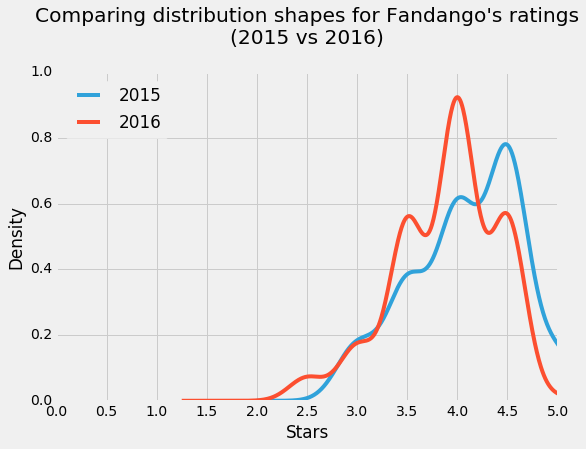

In [26]:
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', figsize = (8, 5.5),legend = True)
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)


plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
          y = 1.07) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0, 5.1, 0.5))
plt.show()

Two aspects are striking on the figure above:

- Both distributions are strongly left skewed.
- The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.

The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

### Comparing Relative Frequency

We now need to analyze more granular information. Let's create relative frequency tables from two dataset so we can have normalized numbers for comparison. 

In [27]:
print('2015' + '\n' + '-' * 16) # To help us distinguish between the two tables immediately and
                                
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [28]:
print('2016' + '\n' + '-' * 16)

fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings. This data might oppose to the idea we drew from kernel density plot about the direction of change.

### Determine the Direction of the Change

We confirmed there is a clear difference between the two distributions. However, the direction of the difference is not as clear as it was on the kernel density plots.

Next, we'll take a couple of summary statistics to get a more precise picture about the direction of the difference.

In [29]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0] # the output of Series.mode() is a bit uncommon
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


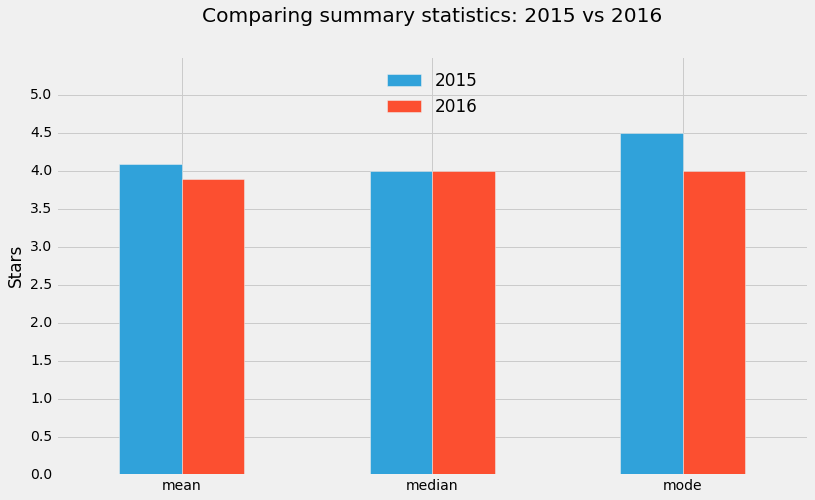

In [32]:
plt.style.use('fivethirtyeight')

summary.plot(kind='bar',figsize=(12,7),rot=0)


plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0, 5.5)
plt.yticks(arange(0, 5.1, .5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

### Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.